In [242]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [243]:
import matplotlib as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [375]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn import preprocessing
import matplotlib.pyplot as plt

# CASE DATA

In [244]:
cases = pd.read_csv("data/us-states.csv")
cases['date'] = cases['date'].astype('datetime64[ns]') 
cases = cases.drop(["fips"], axis=1)
cases = cases.dropna()

# MOBILITY DATA

In [376]:
mob = pd.read_csv("data/Global_Mobility_Report.csv", names=['country_region_code', 'country', 'state', 'sub_region_2','iso_3166_2_code',
                                                            'census_fips_code', 'date', 'retail_recreation', 'grocery_pharmacy', 'parks',
                                                            'transit', 'workplaces', 'residential'], low_memory=False)
mobility = mob.loc[mob['country'] == 'United States']
mobility = mobility.drop(['country_region_code', 'census_fips_code', 'iso_3166_2_code', 'country', 'sub_region_2'], axis=1)
mobility = mobility.dropna()
mobility['date'] = mobility['date'].astype('datetime64[ns]') 
mobility = mobility.reset_index().drop(['index'], axis=1)

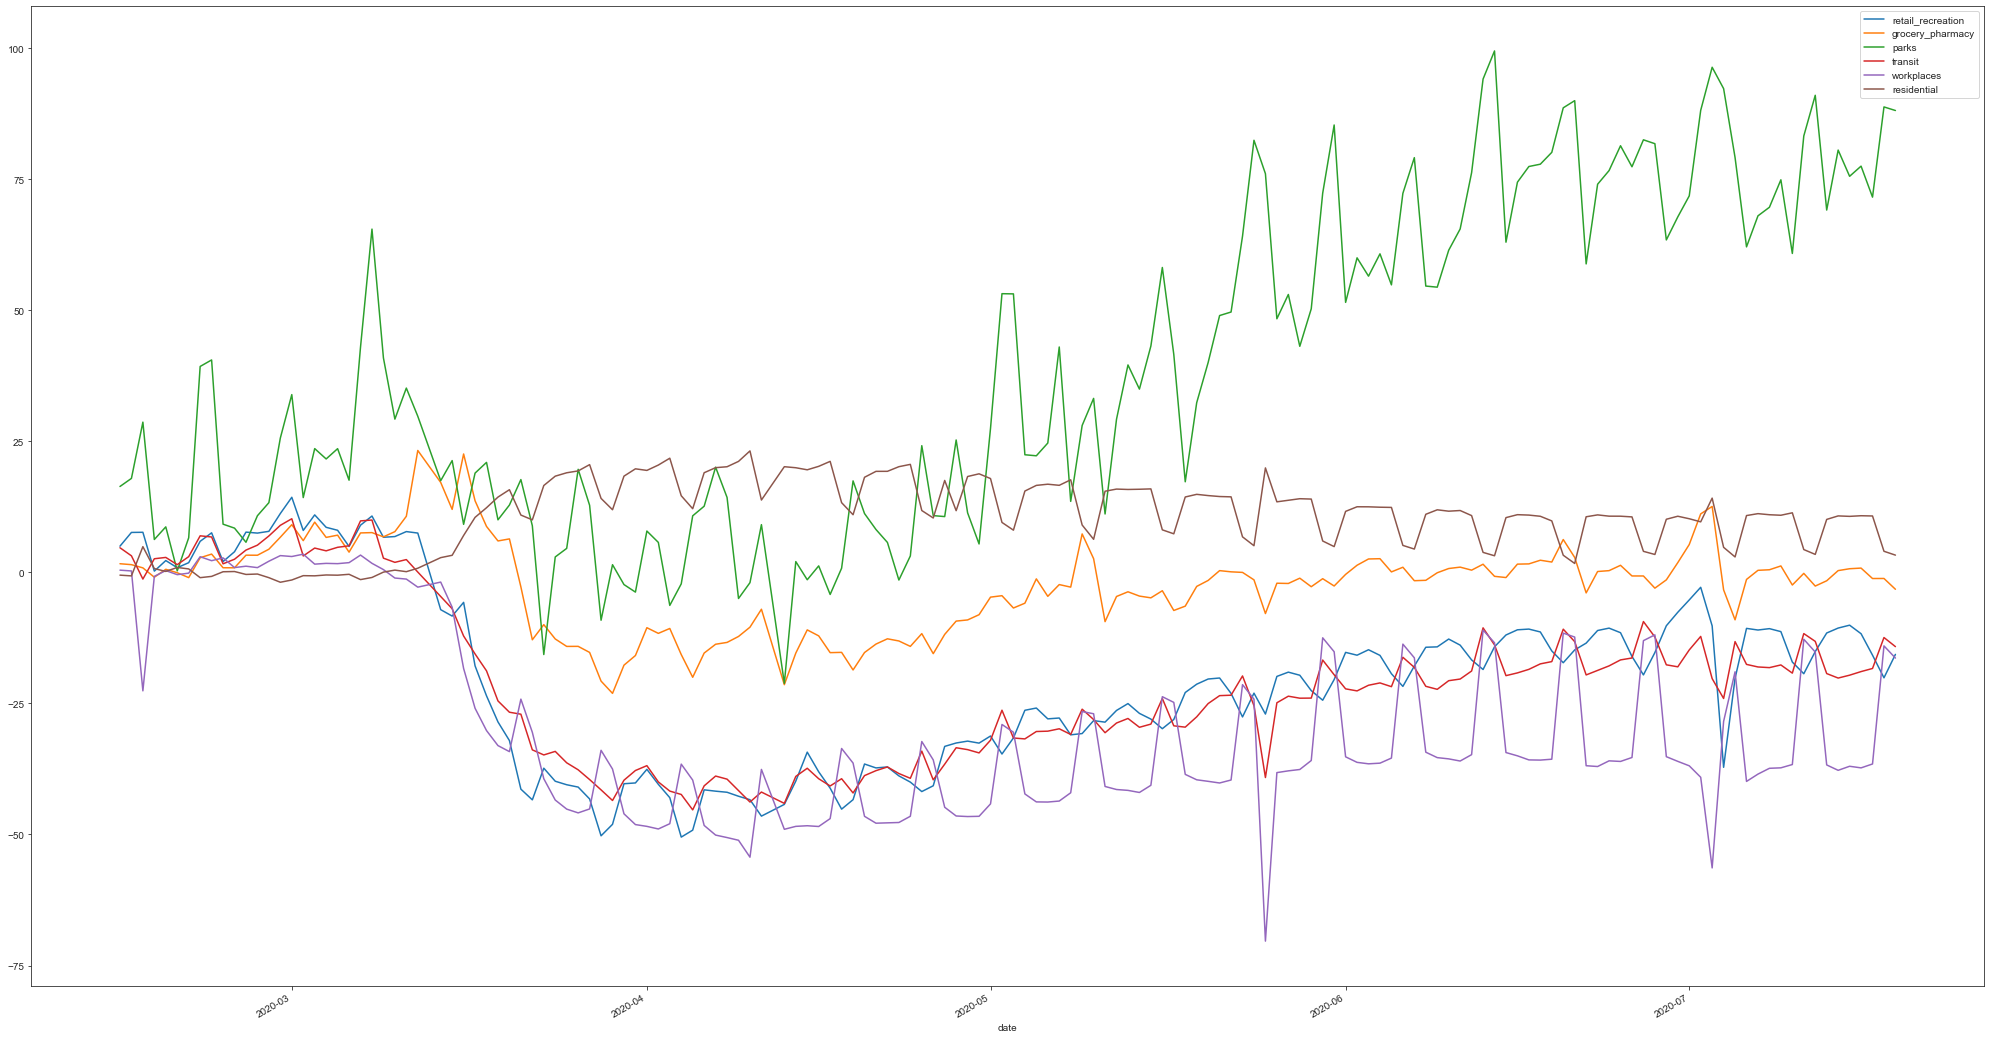

In [380]:
# Visualize the mobility data over time
mob_date = mobility.sort_index(level=['date'])
mob_date['retail_recreation'] = mob_date['retail_recreation'].astype('double') 
mob_date['grocery_pharmacy'] = mob_date['grocery_pharmacy'].astype('double') 
mob_date['parks'] = mob_date['parks'].astype('double') 
mob_date['transit'] = mob_date['transit'].astype('double') 
mob_date['workplaces'] = mob_date['workplaces'].astype('double') 
mob_date['residential'] = mob_date['residential'].astype('double') 
mob_date = mob_date.groupby(['date']).mean()
# Remove any outliers
z_scores = zscore(mob_date)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
mob_date = mob_date[filtered_entries]
# Plot the overall change in mobility over time
mob_date.plot(figsize=(35,20))

# RESTAURANT DATA

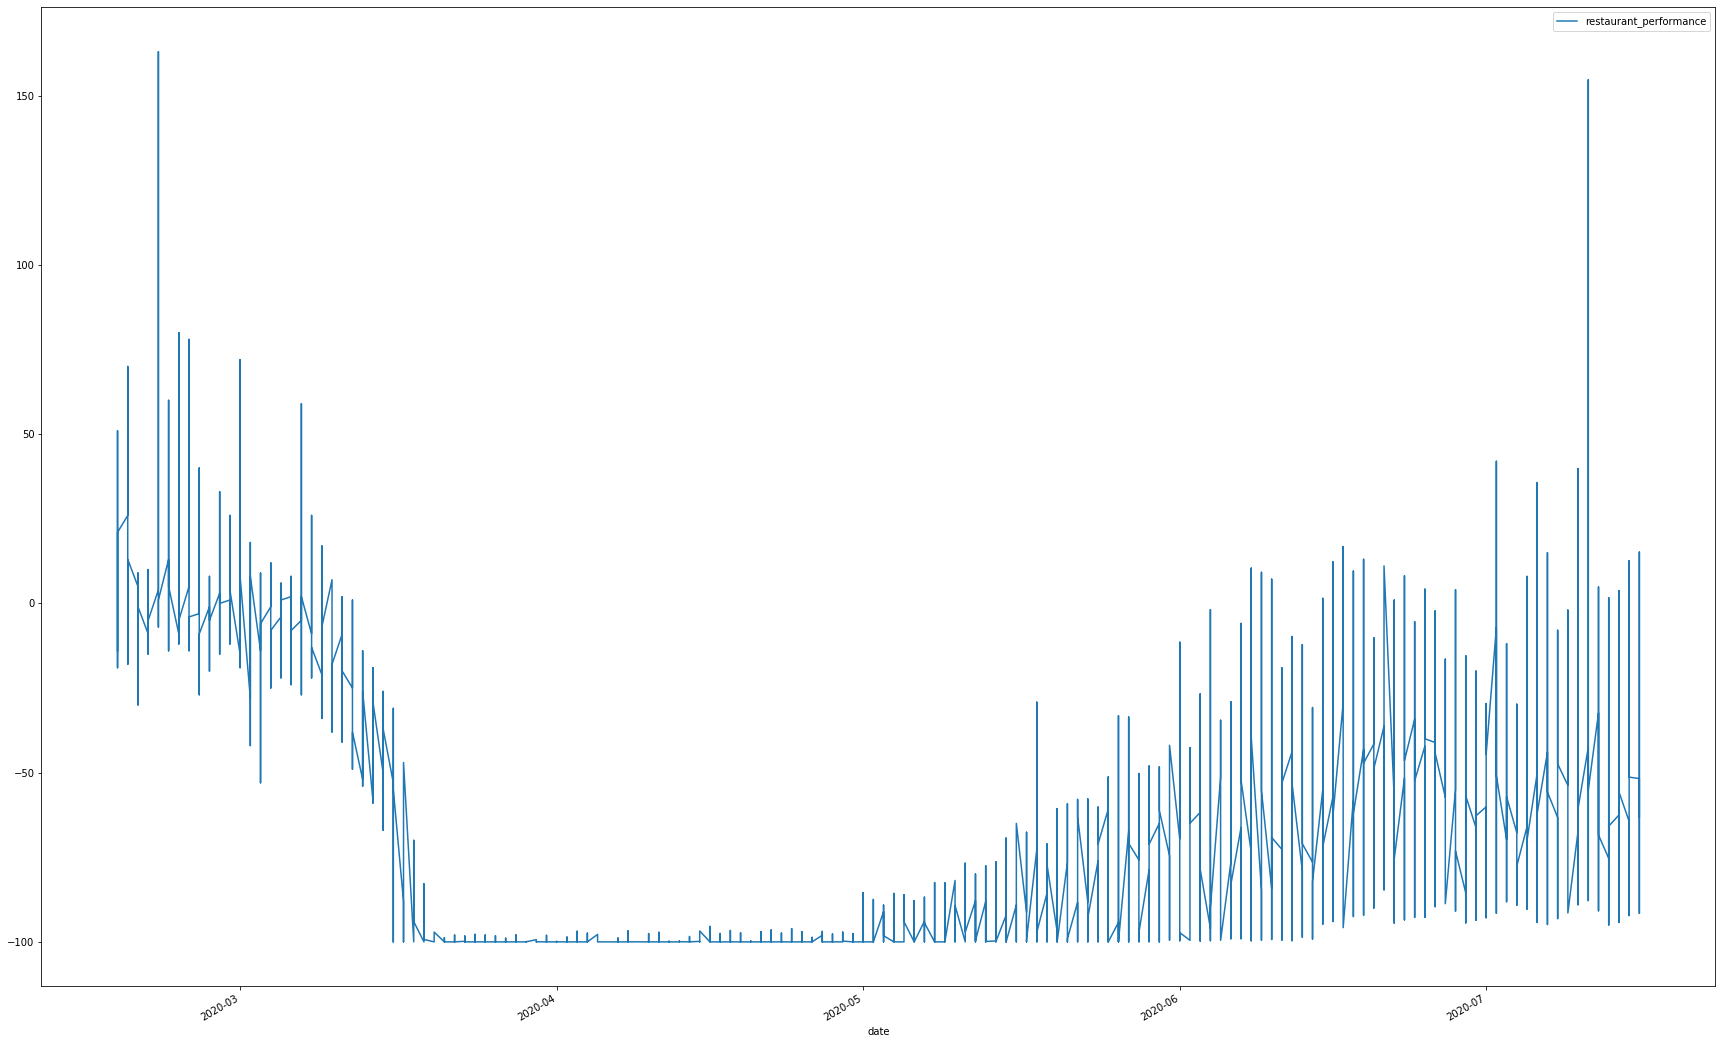

In [247]:
# Restaurant data
rest = pd.read_csv("data/YoY_Seated_Diner_Data.csv")
restaurants = rest[8:57]
restaurants = restaurants.drop([11, 12, 28, 36, 45, 46, 47, 39, 42, 9, 22, 53])
restaurants = restaurants.reset_index().drop(['index', 'Type'], axis=1)
restaurants = restaurants.melt(id_vars=["Name"], var_name="date", value_name="restaurant_performance")
restaurants = restaurants.sort_values(['Name', 'date'], ascending=[True, True])
def add_year(date_in_some_format):
    date_as_string = str(date_in_some_format)
    new_date = date_as_string + '/2020'
    return new_date
restaurants['date'] = restaurants['date'].apply(add_year)
restaurants['date'] = restaurants['date'].astype('datetime64[ns]') 
restaurants = restaurants.rename({'Name':'state'}, axis='columns')
restaurants.plot(x='date', y='restaurant_performance', figsize=(30,20))

# COMBINE ALL DATA

Merge all data into one dataframe

In [294]:
all_data = pd.merge(mobility, cases, on=["state", "date"], how="left")
all_data = all_data.dropna()
all_data = pd.merge(all_data, restaurants, on=["state", "date"], how="left")
all_data = all_data.dropna()
all_data = all_data.reset_index().drop(['index'], axis=1)
all_data['date'] = all_data['date'].astype('datetime64[ns]') 
all_data_new = all_data.copy()
# Print
all_data

,state,date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance
0,Alabama,2020-03-13,7,32,26,7,-2,0,6.0,0.0,-24.00
1,Alabama,2020-03-14,1,28,55,12,4,0,12.0,0.0,-28.00
2,Alabama,2020-03-15,-7,16,16,6,-4,2,23.0,0.0,-38.00
3,Alabama,2020-03-16,-2,24,22,2,-10,4,29.0,0.0,-57.00
4,Alabama,2020-03-17,-11,17,25,-1,-17,7,39.0,0.0,-74.00
...,...,...,...,...,...,...,...,...,...,...,...
62774,Wisconsin,2020-06-29,-7,-5,112,8,-31,9,31103.0,786.0,-67.14
62775,Wisconsin,2020-07-03,-5,5,194,25,-57,11,33565.0,804.0,-49.03
62776,Wisconsin,2020-07-07,-7,-6,123,24,-33,10,35834.0,817.0,-58.37
62777,Wisconsin,2020-07-09,-6,-3,103,38,-31,10,37358.0,821.0,-63.04


# Plot all data

In [291]:
all_normalized = all_data.copy()

# Normalize the values

scaler = preprocessing.MinMaxScaler()
all_normalized[['cases', 'deaths', 'restaurant_performance', 'retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential', 'cases', 'deaths', 'restaurant_performance']] = scaler.fit_transform(all_normalized[['cases', 'deaths', 'restaurant_performance', 'retail_recreation', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential', 'cases', 'deaths', 'restaurant_performance']])

#drop Nan values
all_normalized = all_normalized.replace([np.inf, -np.inf], np.nan)
all_normalized = all_normalized.dropna()

all_normalized = all_normalized.groupby(['date']).mean()
all_normalized

,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance
date,,,,,,,,,
2020-02-18,0.433746,0.491612,0.146690,0.407594,0.748982,0.143991,0.000005,0.000000,0.385385
2020-02-19,0.435341,0.492359,0.141706,0.403017,0.756450,0.142239,0.000005,0.000000,0.392773
2020-02-20,0.438677,0.495563,0.140421,0.402987,0.751731,0.145331,0.000006,0.000000,0.391506
2020-02-21,0.439904,0.490894,0.144350,0.408781,0.758772,0.135317,0.000008,0.000000,0.380353
2020-02-22,0.452912,0.508326,0.164876,0.410299,0.775797,0.119278,0.000008,0.000000,0.403285
...,...,...,...,...,...,...,...,...,...
2020-07-12,0.349648,0.465935,0.244395,0.326748,0.617164,0.219892,0.347304,0.156010,0.164202
2020-07-13,0.367735,0.475294,0.215381,0.300432,0.422395,0.371193,0.359931,0.157200,0.135613
2020-07-14,0.371901,0.488910,0.230922,0.295994,0.412654,0.387056,0.365411,0.157387,0.141764


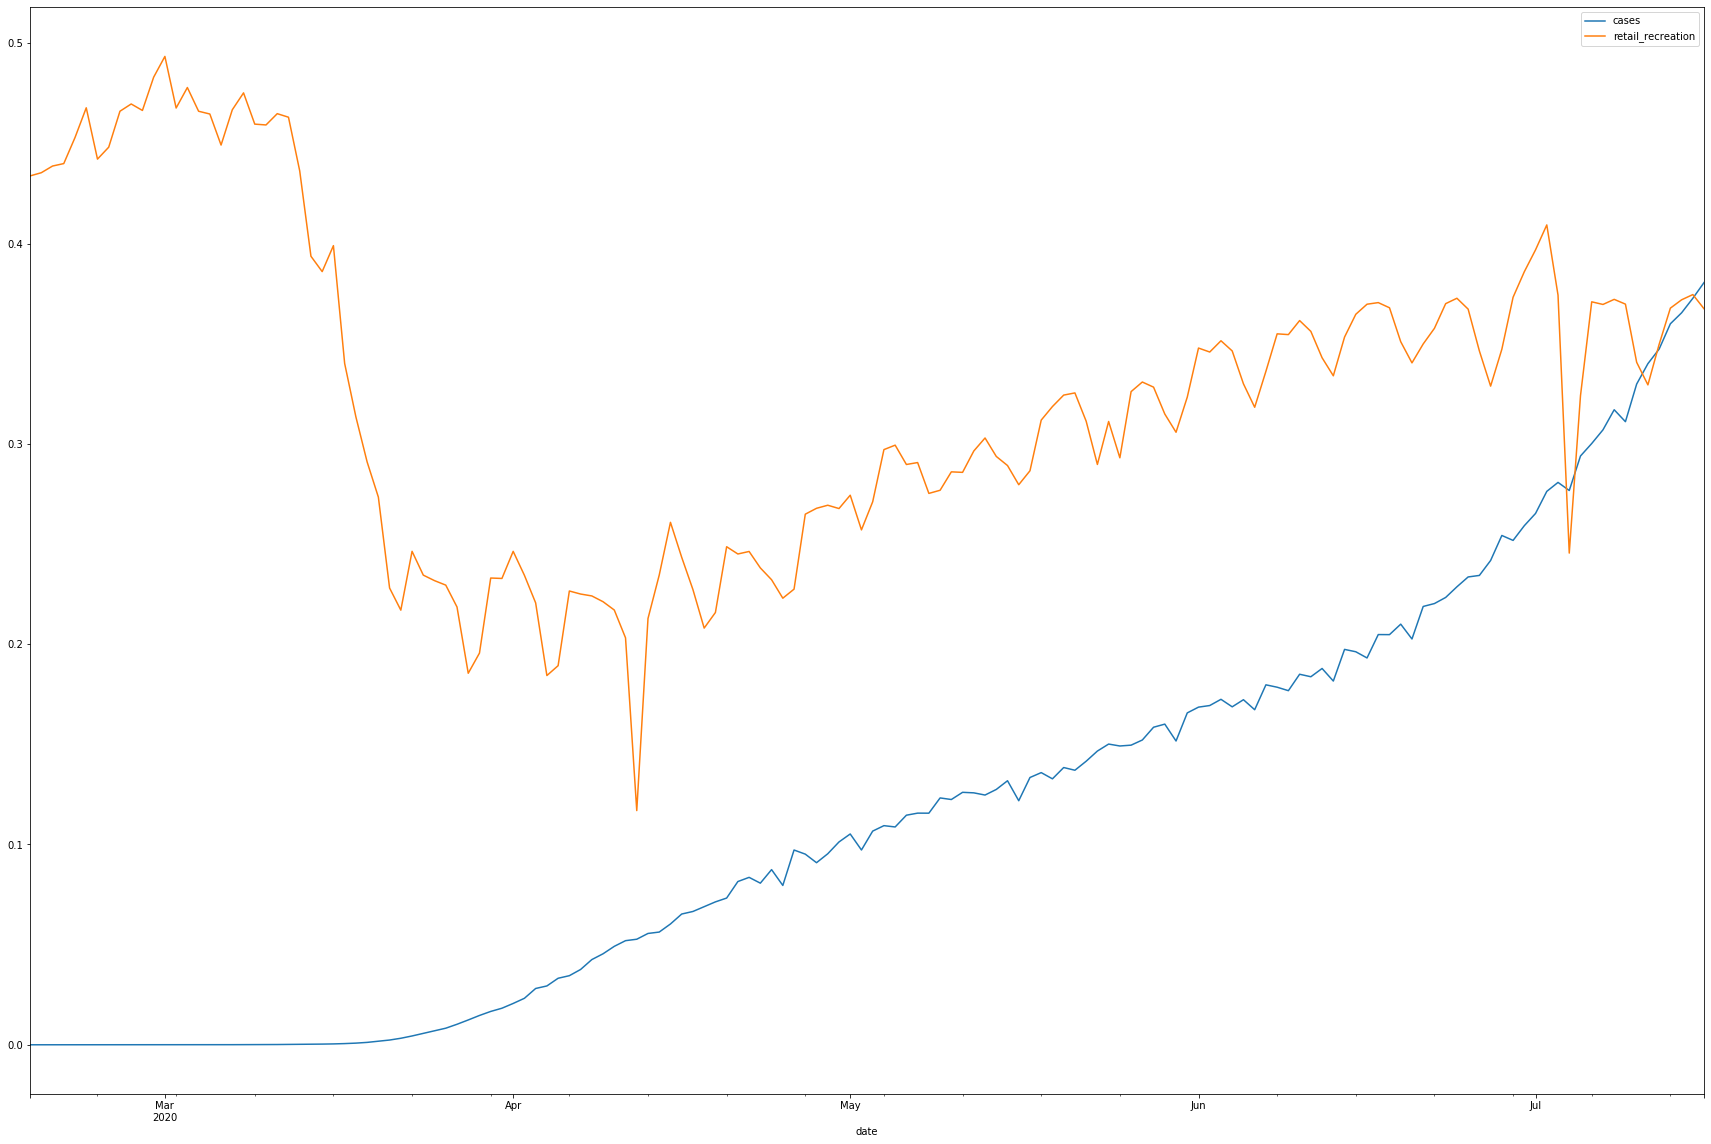

In [282]:
all_normalized.reset_index().plot(x='date', y=['cases', 'retail_recreation'], figsize=(30,20))

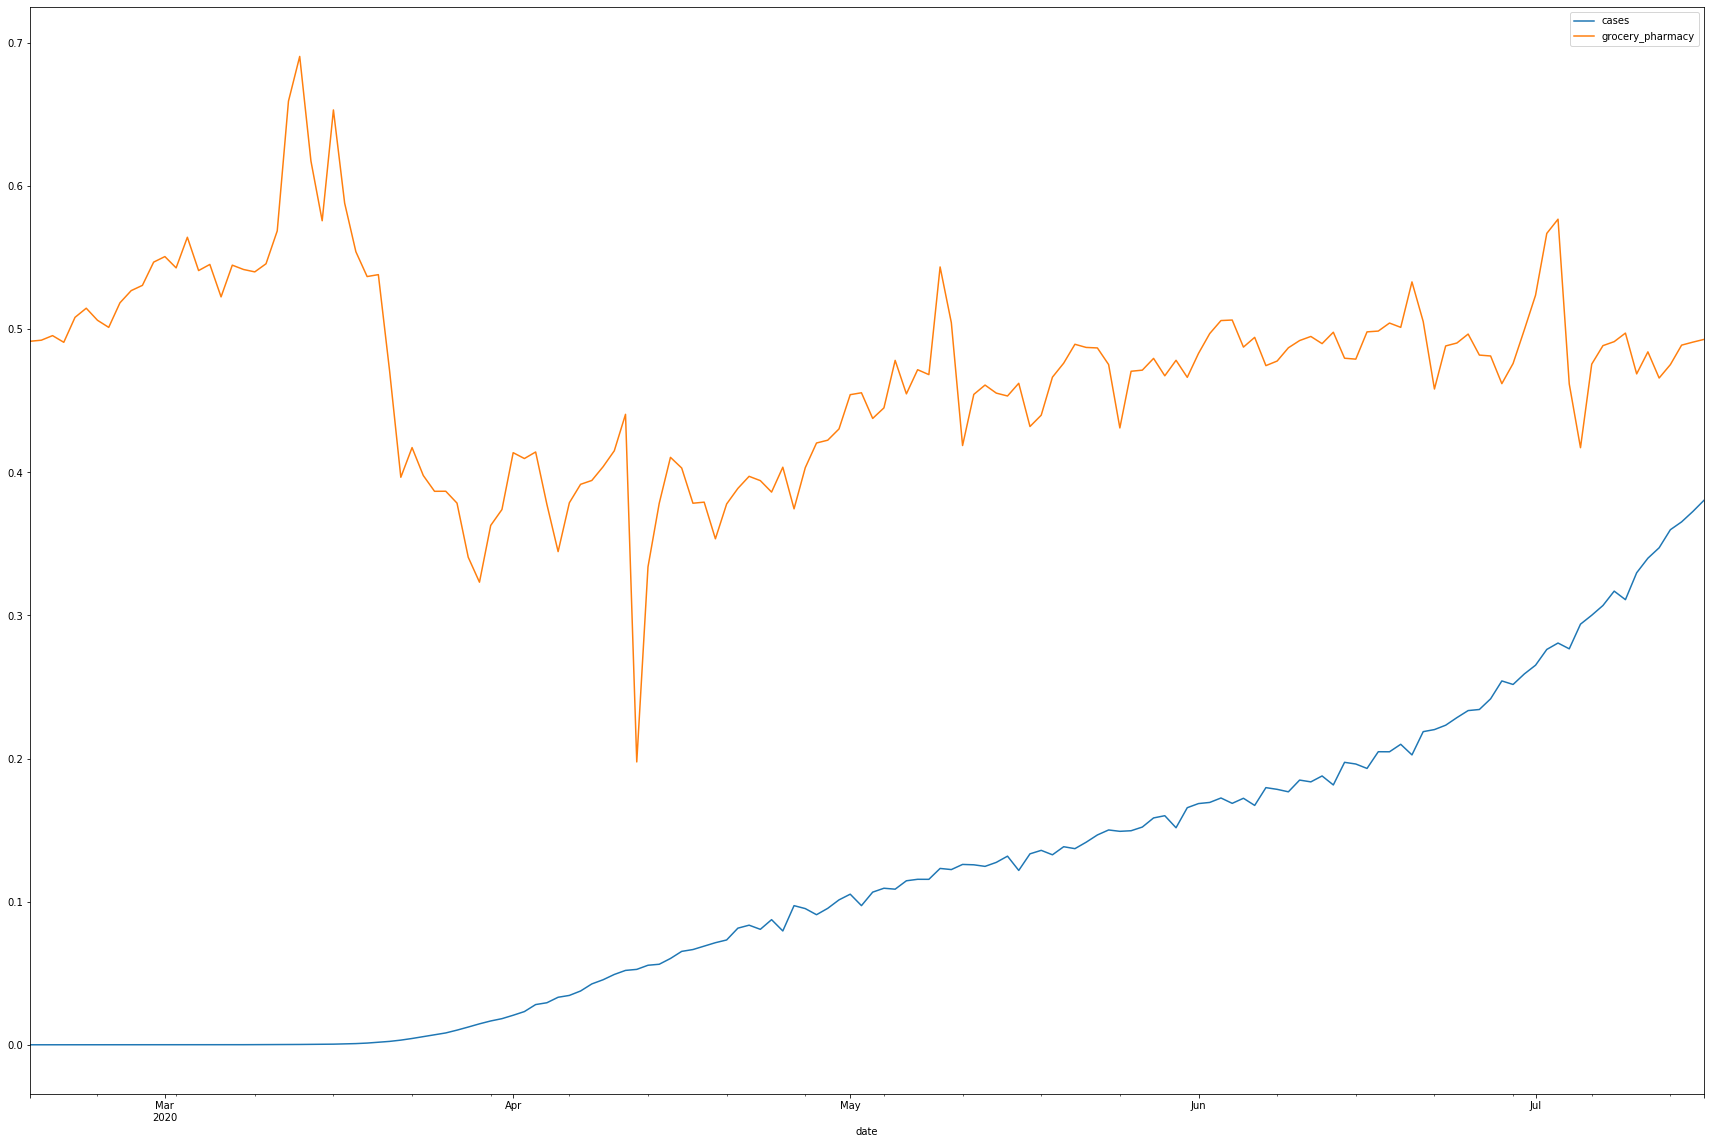

In [261]:
all_normalized.reset_index().plot(x='date', y=['cases', 'grocery_pharmacy'], figsize=(30,20))

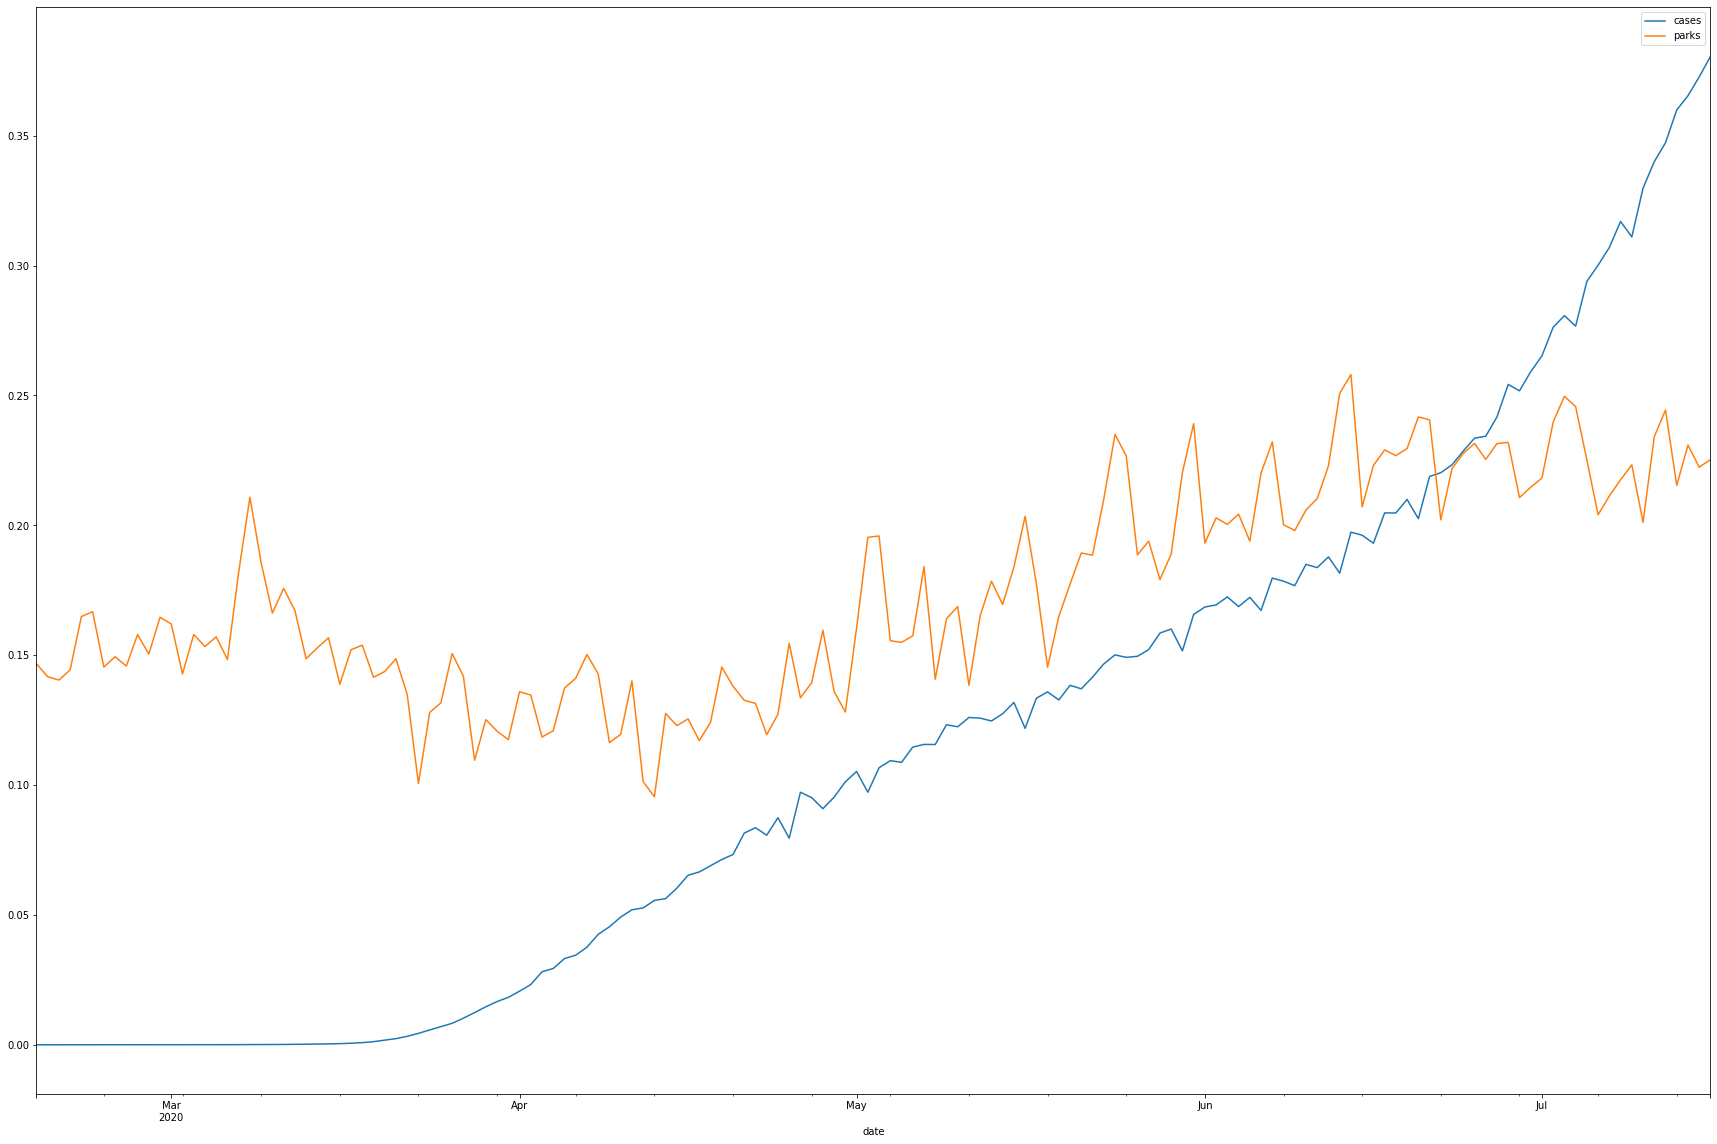

In [255]:
all_normalized.reset_index().plot(x='date', y=['cases', 'parks'], figsize=(30,20))

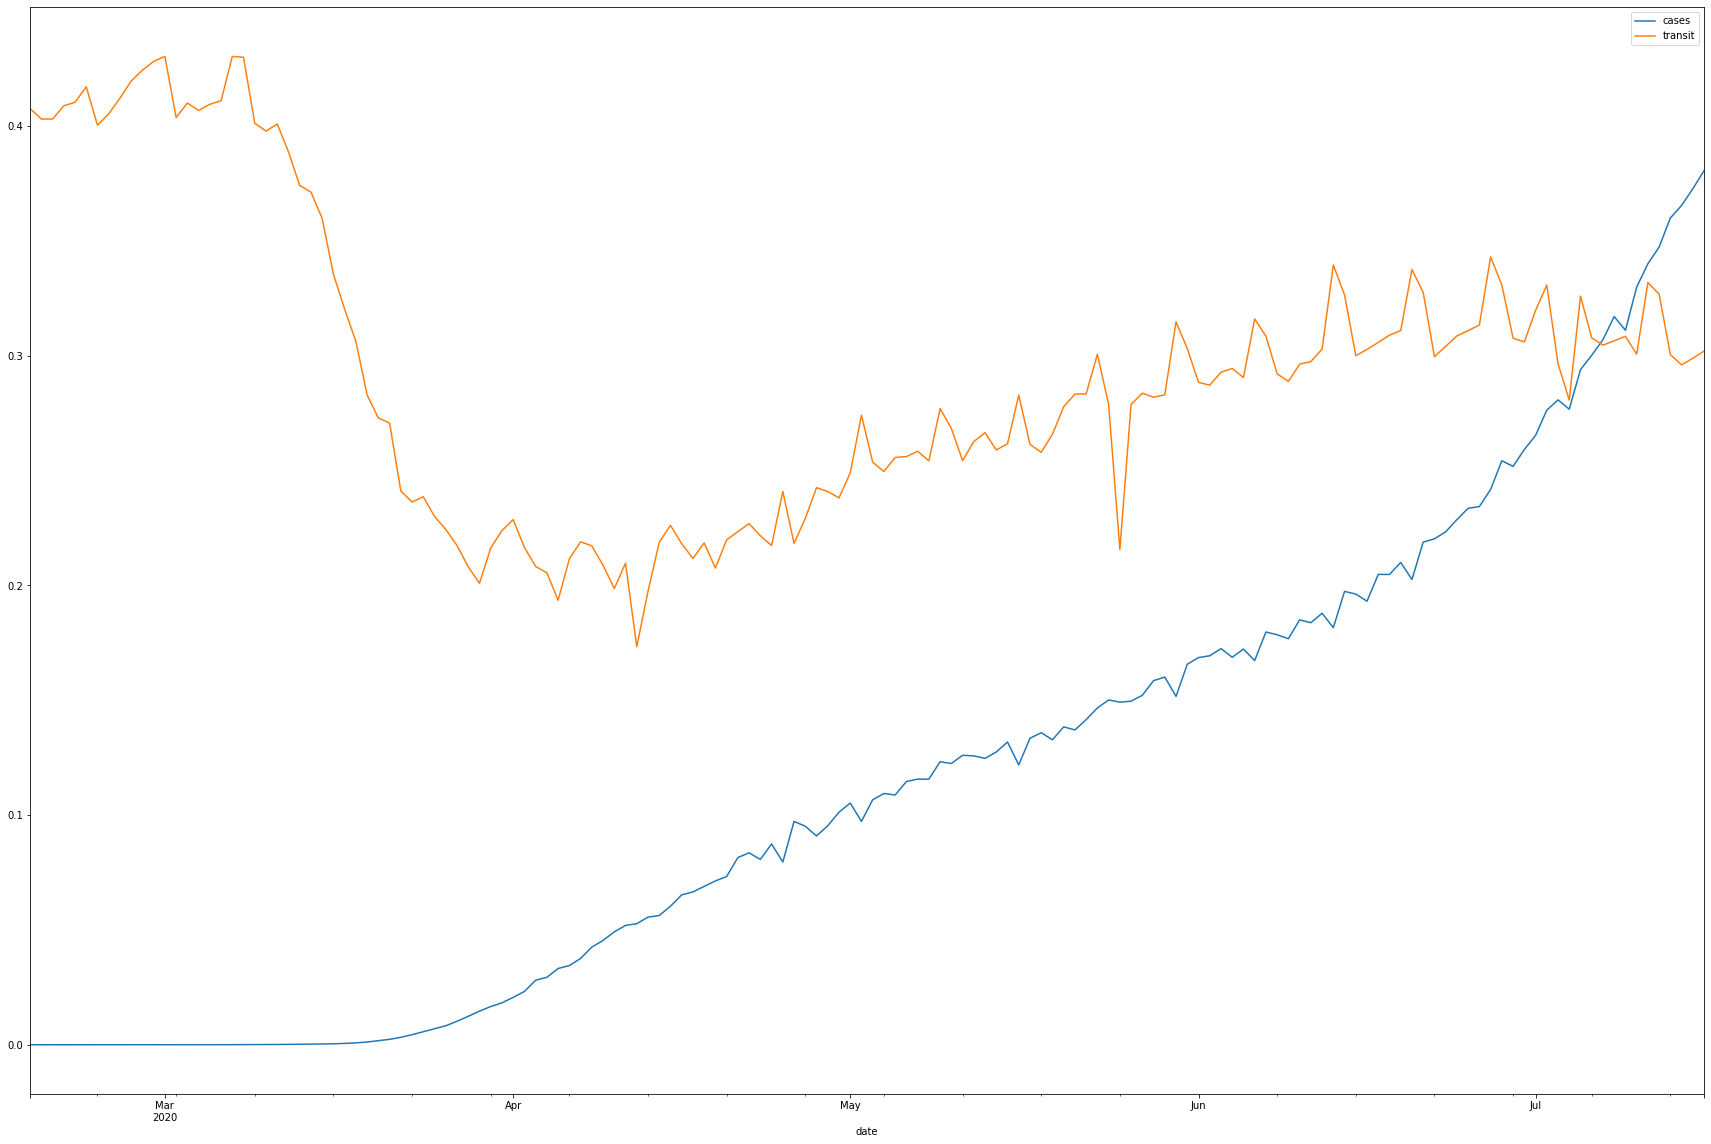

In [258]:
all_normalized.reset_index().plot(x='date', y=['cases', 'transit'], figsize=(30,20))

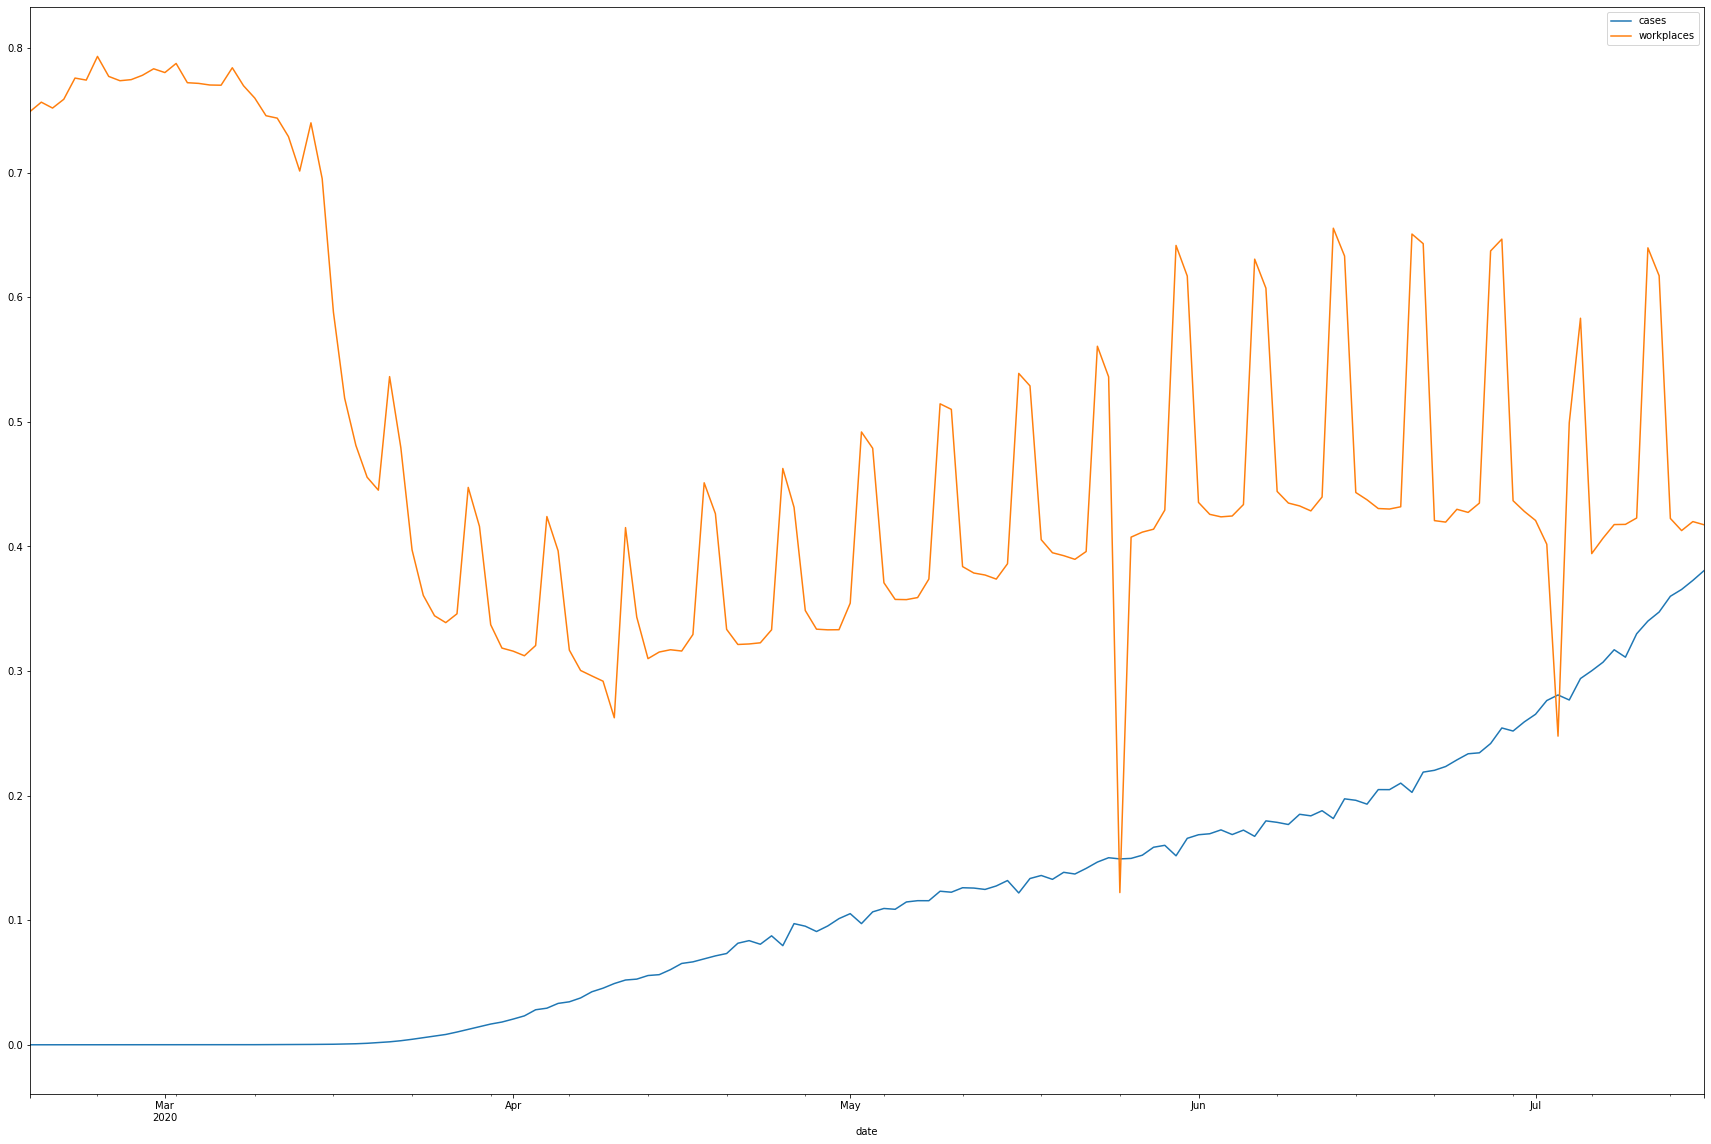

In [259]:
all_normalized.reset_index().plot(x='date', y=['cases', 'workplaces'], figsize=(30,20))

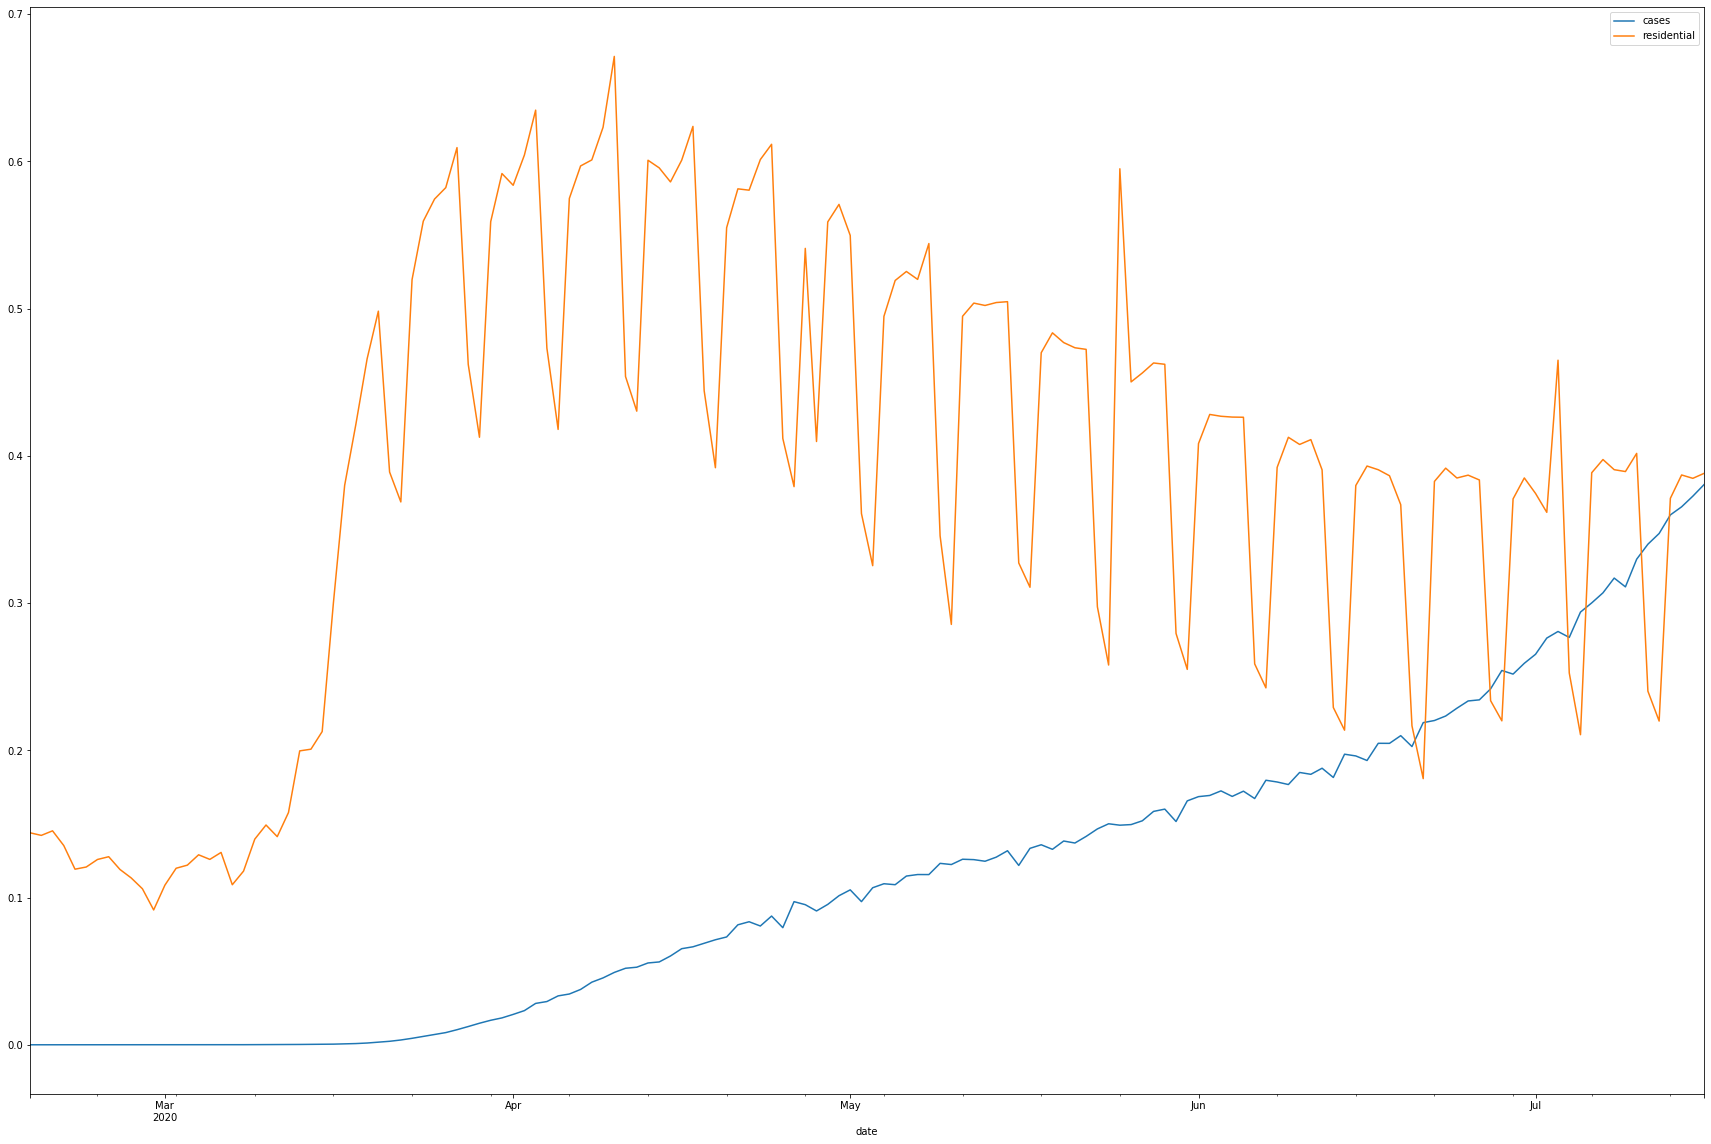

In [262]:
all_normalized.reset_index().plot(x='date', y=['cases', 'residential'], figsize=(30,20))

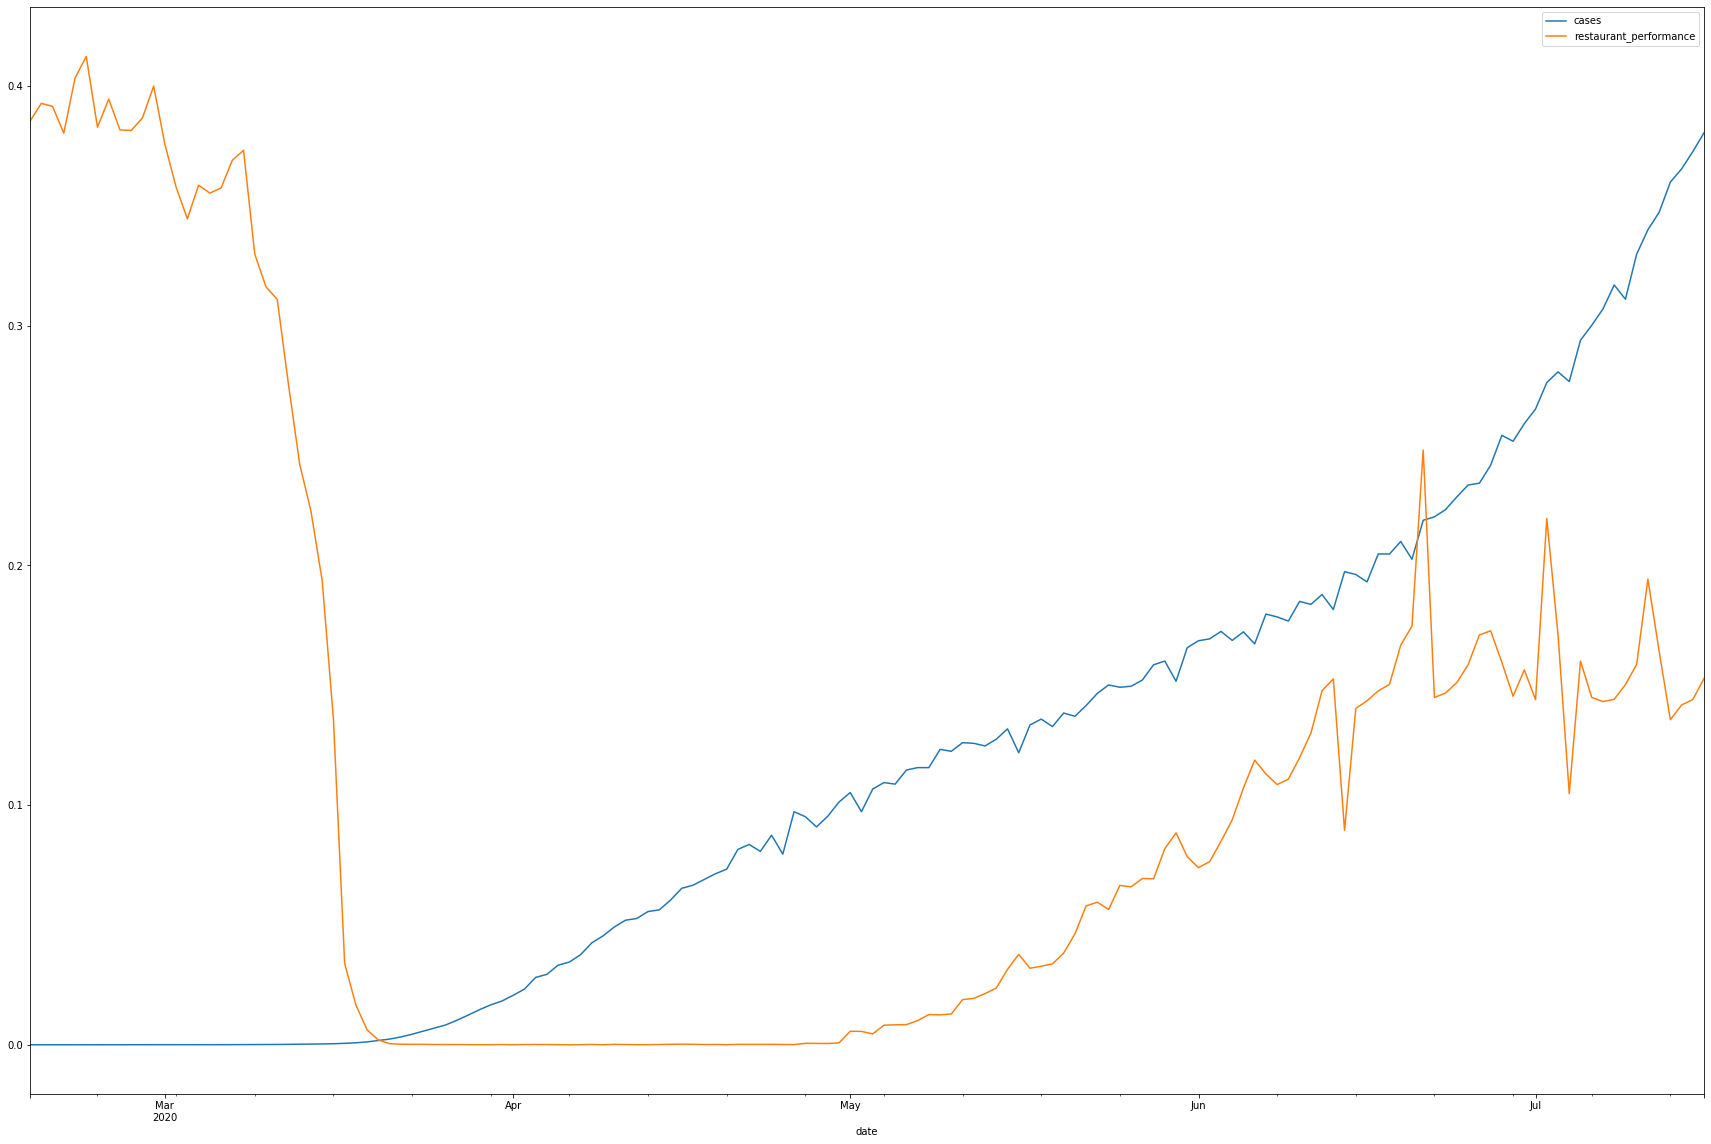

In [257]:
all_normalized.reset_index().plot(x='date', y=['cases', 'restaurant_performance'], figsize=(30,20))

# ALL DATA BY STATE

In [379]:
# Create new dataframe from the percent change in mobility in each area and group by state
change = all_data_new.sort_index(level=['state', 'date'])

change['diff_cases'] = (change.groupby('state')['cases'].apply(pd.Series.diff))

#drop Nan values
change = change.replace([np.inf, -np.inf], np.nan)
change = change.dropna()

change['retail_recreation'] = change['retail_recreation'].astype(int)
change['grocery_pharmacy'] = change['grocery_pharmacy'].astype(int)
change['parks'] = change['parks'].astype(int)
change['transit'] = change['transit'].astype(int)
change['workplaces'] = change['workplaces'].astype(int)
change['residential'] = change['residential'].astype(int)

state = change.groupby(['state']).mean()

state = state.sort_values(['cases'])
state

,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,cases,deaths,restaurant_performance,diff_cases
state,,,,,,,,,,
Hawaii,-42.873194,-24.012841,-48.544141,-62.850722,-35.669342,14.353130,570.823435,12.234350,-89.701862,2.069021
Oregon,-18.778523,0.019016,52.374161,-19.865772,-30.789150,9.282998,3587.252237,105.380313,-78.383003,3.012304
Oklahoma,-11.871681,4.244838,28.772861,-4.411504,-27.361357,8.648968,5642.514749,212.824484,-65.870988,34.572271
District of Columbia,-53.610687,-22.564885,-40.335878,-65.648855,-52.969466,19.656489,5737.977099,293.450382,-90.580534,84.541985
New Mexico,-21.721267,3.760181,11.880543,-23.827149,-33.116742,11.748416,5840.619910,239.247059,-83.539041,14.600905
Kansas,-18.003565,0.424242,72.577540,-4.543672,-30.668449,10.016043,6233.953654,133.661319,-74.718538,37.918004
Kentucky,-21.907916,2.478191,53.371567,-20.684976,-34.137318,11.631664,6543.242326,270.707593,-77.319176,15.649435
Nebraska,-16.138196,1.111324,75.034549,-9.990403,-26.234165,9.629559,7294.633397,99.940499,-63.095816,40.355086
Rhode Island,-23.828767,-8.417808,73.187215,-43.020548,-35.488584,13.783105,7673.680365,344.520548,-64.646963,36.210046


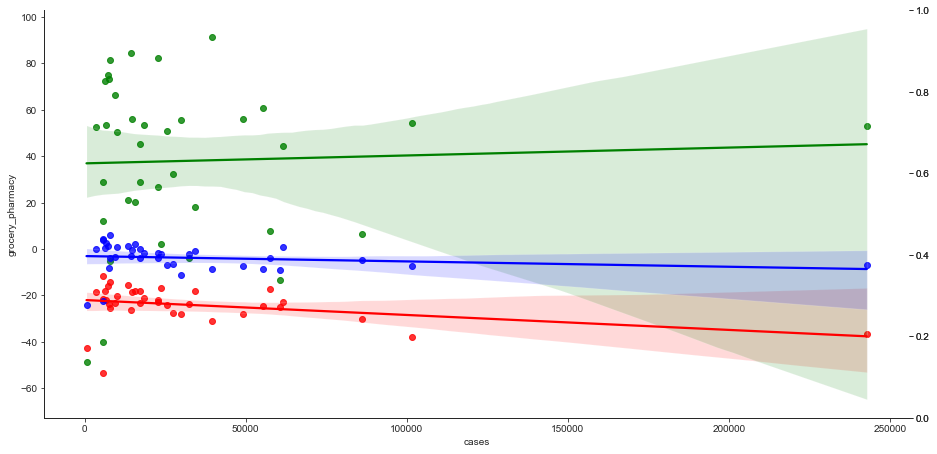

In [372]:
# Plot the number of cases against the change in retail, parks, grocery and pharmacy for each state
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['cases'], state['retail_recreation'], color='r', ax=ax)
ax2 = ax.twinx()
sns.regplot(state['cases'], state['parks'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(state['cases'], state['grocery_pharmacy'], ax=ax, color='b')
sns.despine()

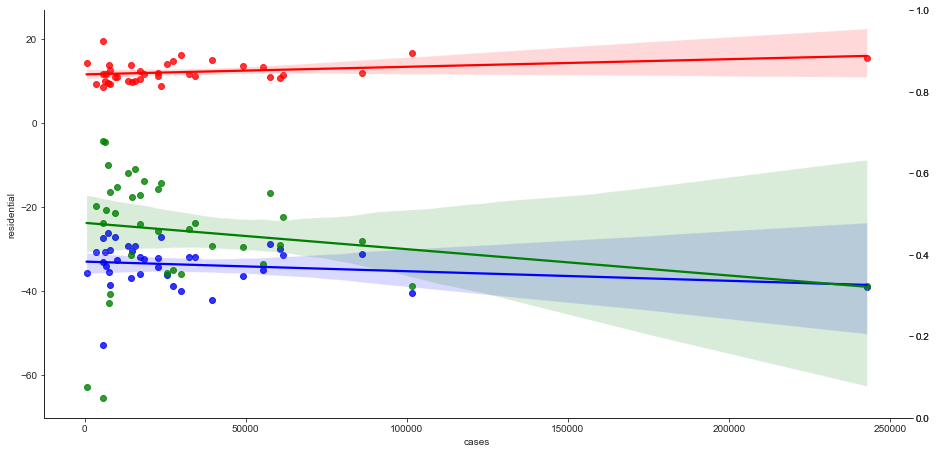

In [374]:
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 7.5)
sns.regplot(state['cases'], state['workplaces'], color='b', ax=ax)
ax2 = ax.twinx()
sns.regplot(state['cases'], state['transit'], ax=ax, color='g')
ax2 = ax.twinx()
sns.regplot(state['cases'], state['residential'], ax=ax, color='r')
sns.despine()

In [338]:
# Create new dataframe from the percent change in mobility in each area and group by state
change = all_data_new.sort_index(level=['state', 'date'])

change['pct_ch_rec'] = (change.groupby('state')['retail_recreation'].apply(pd.Series.pct_change))
change['pct_ch_groc'] = (change.groupby('state')['grocery_pharmacy'].apply(pd.Series.pct_change))
change['pct_ch_parks'] = (change.groupby('state')['parks'].apply(pd.Series.pct_change))
change['pct_ch_transit'] = (change.groupby('state')['transit'].apply(pd.Series.pct_change))
change['pct_ch_work'] = (change.groupby('state')['workplaces'].apply(pd.Series.pct_change))
change['pct_ch_residential'] = (change.groupby('state')['residential'].apply(pd.Series.pct_change))
change['pct_ch_rest'] = (change.groupby('state')['restaurant_performance'].apply(pd.Series.pct_change))
change['pct_ch_cases'] = (change.groupby('state')['cases'].apply(pd.Series.pct_change))

# Calcualte the percent daily change in cases and deaths for each state
#change['pct_ch_cases'] = (change.groupby('state')['cases'].apply(pd.Series.diff))

#drop Nan values
change = change.replace([np.inf, -np.inf], np.nan)
change = change.dropna()

date_norm = change.groupby(['state']).mean()

date_norm = date_norm.drop(['cases', 'deaths', 'restaurant_performance'], axis=1)

date_norm  = date_norm.sort_values(['pct_ch_cases'])

date_norm

,pct_ch_rec,pct_ch_groc,pct_ch_parks,pct_ch_transit,pct_ch_work,pct_ch_residential,pct_ch_rest,pct_ch_cases
state,,,,,,,,
Hawaii,0.026988,0.021928,0.083062,-0.017066,0.036004,0.051371,0.013248,0.059770
Nebraska,0.051440,-0.556621,-0.314446,-0.072658,0.150598,0.165422,-0.997131,0.061216
District of Columbia,0.017368,0.050826,0.379566,0.015694,0.089796,0.131546,0.006701,0.062463
Washington,0.066174,-0.100887,0.018952,-0.069646,0.049865,0.108239,-0.057221,0.073166
California,0.035102,-0.016961,-0.111067,-0.070416,0.092427,0.065998,-0.004513,0.075016
Oregon,-0.007035,-0.034746,-0.218499,0.041860,0.046955,0.072464,-0.003289,0.079353
Arizona,-0.047921,0.032567,-0.016095,-0.018347,0.020597,0.034813,-0.001663,0.087618
Illinois,0.062539,-0.263144,-0.423309,-0.050025,0.104387,0.182478,-0.132608,0.087911
Massachusetts,0.016400,-0.069911,-0.483409,-0.129892,0.096577,0.136586,-0.236972,0.100208
